In [3]:
import numpy as np
import matplotlib.pyplot as plt
# from Thompson import *

In [4]:
num_of_bandits = 3
num_of_users = 5

In [5]:
bandit_contexts = np.random.rand(num_of_bandits,10)*2

In [6]:
user_contexts = np.random.rand(num_of_users,10)

In [7]:
user_contexts @ bandit_contexts.T

array([[ 0.56021382, -1.41487689,  0.59850292],
       [ 0.18894883, -0.98969763,  1.36041268],
       [ 0.42363474, -2.02865632,  2.0215775 ],
       [ 0.99570803, -1.43171744,  2.41593444],
       [ 0.26695382, -1.38377885,  1.76179341]])

In [8]:
class linucb_arm():
    
    
    def __init__(self, num_features, alpha):
        
        self.num_features=num_features
        self.alpha = alpha
        self.A = np.identity(num_features)
        self.b = np.zeros([num_features,1])
        
    def pull(self, context):
        context=context.reshape(-1,1) # transforming context into column vector for mathematical consistency
        A_inv = np.linalg.inv(self.A)
        theta = A_inv@self.b
        reward_ucb = theta.T@context + self.alpha * np.sqrt(context.T @ A_inv @ context)
        
        return reward_ucb
    
    def update(self,context,reward):
        context = context.reshape(-1,1)
        self.A=self.A+context@context.T
        self.b=self.b+reward*context

In [9]:
class linUCB():
    
    def __init__(self, num_bandits, num_features, alpha):
        
        self.bandits = [linucb_arm(num_features,alpha) for i in range(num_bandits)]
        self.alpha = alpha
        self.last_pull = None
        self.last_context = []
        self.reward_collector = []
        
    def ask(self,context): 
        
        self.last_pull = np.argmax([bandit.pull(context) for bandit in self.bandits])
        self.last_context = context
        
        return self.last_pull
    
    def update(self,reward):
        assert ((self.last_pull != None) and  (len(self.last_context) != 0))
        self.bandits[self.last_pull].update(self.last_context,reward)
        self.last_pull = None
        self.last_context = []
        if len(self.reward_collector)==0:
            self.reward_collector.append(reward)
        else:
            self.reward_collector.append(self.reward_collector[-1]+reward)
        
    def plot(self):
        fig = plt.figure(figsize = (10, 5))

        plt.plot([i for i in range(len(self.reward_collector))], self.reward_collector,label=f"{self.__class__.__name__}") # plot cumsum per bandit.

        plt.legend()
        plt.xlabel("Timestep")
        plt.ylabel("Log Cummulative Reward")
        plt.title("Log Commulative Reward of LinUCB Over Time")
        plt.yscale("log")
        plt.show()  

In [10]:
class linucb_test_experiment_manager():
    
    def __init__(self, user_contexts, bandit_contexts, num_iterations, alpha):
        
        self.user_contexts = user_contexts
        self.bandit_contexts = bandit_contexts
        self.num_iterations = num_iterations
        self.bandits = [linucb_arm(len(self.user_contexts[0]),alpha) for i in range(len(self.bandit_contexts))]
        self.reward_matrix = self.user_contexts @ self.bandit_contexts.T
        self.optimal_reward_per_user  = np.max(self.reward_matrix, axis=1)
        
        self.reward_per_user = [[] for i in self.user_contexts]
        self.num_optimal=0
        self.experiment_indicator = False
        
    def experiment(self):
        self.experiment_indicator = True
        
        for iter_ in range(self.num_iterations):
            for user in range(len(self.user_contexts)):
                
                current_context = self.user_contexts[user]
                chosen_bandit = np.argmax([bandit.pull(current_context) for bandit in self.bandits])
                reward = self.reward_matrix[user][chosen_bandit]
                self.reward_per_user[user].append(reward)
                
                if self.optimal_reward_per_user[user] == reward: self.num_optimal+=1
                    
                
                self.bandits[chosen_bandit].update(current_context,reward)
        
        print("Number of optimal choices made:",self.num_optimal)
        
        per_user_optimal_reward_estimate = []
        for user in range(len(self.user_contexts)):
                current_context = self.user_contexts[user]
                per_user_optimal_reward_estimate.append(np.max([bandit.pull(current_context) for bandit in self.bandits]))
                
        return np.array(per_user_optimal_reward_estimate)
    
    def plot(self):
        assert self.experiment_indicator==True
        
        fig = plt.figure(figsize = (10, 5))

        plt.subplot(1,2,1)
        for it in range(len(self.reward_per_user)):
            plt.plot([i for i in range(len(self.reward_per_user[it]))], np.cumsum(self.reward_per_user[it]),label=f"user{it}") # plot cumsum per bandit.
            
        plt.legend()
        plt.xlabel("Timestep")
        plt.ylabel("Log Cummulative Reward")
        plt.title("Log Commulative Reward of LinUCB Over Time")
        plt.yscale("log")

        plt.subplot(1,2,2)
        plt.bar(["Optimal", "Non-optimal"],[self.num_optimal,self.num_iterations*len(self.user_contexts)-self.num_optimal],label=f"LinUCB")
        plt.legend()
        plt.ylabel("#optimal choices")
        plt.title("Number of optimal choices during the experiment")

        plt.show() 
        

In [11]:
reward_per_user = np.random.rand(2,100)
num_optimal = 4000
num_optimal2 = 3000

In [12]:
linucb_experiment = linucb_test_experiment_manager(user_contexts=user_contexts, bandit_contexts=bandit_contexts, num_iterations=1000, alpha=1)

In [13]:
linucb_experiment.experiment()

Number of optimal choices made: 4823


array([0.63501158, 1.39278259, 2.05172346, 2.44662811, 1.79357742])

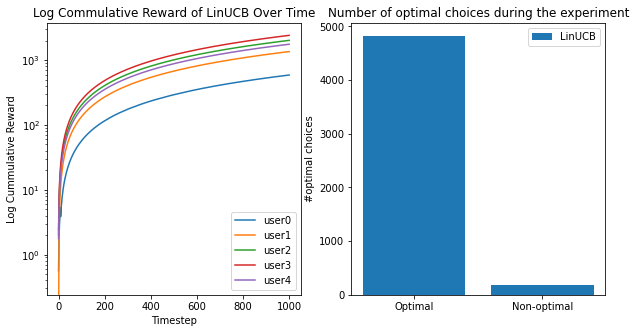

In [14]:
linucb_experiment.plot()

In [13]:
thompson_experiment = thompson_test_experiment_manager(user_contexts=user_contexts, bandit_contexts=bandit_contexts, num_iterations=1000)

In [14]:
thompson_experiment.experiment()

Number of optimal choices made: 4919


array([ 1.04279072, -1.40154254, -0.25930339])

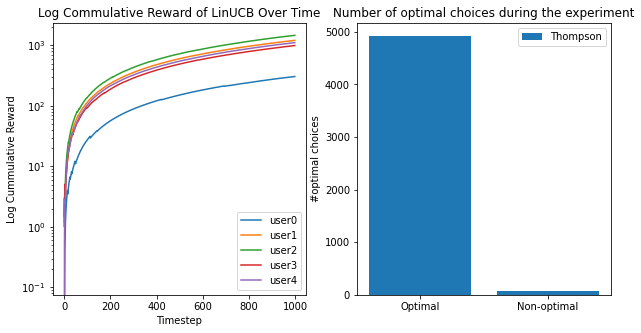

In [15]:
thompson_experiment.plot()

In [16]:
thompson = Thompson(num_bandits=num_of_bandits, num_features=10, alpha=1)

In [17]:
linucb = linUCB(num_bandits=num_of_bandits, num_features=10, alpha=1)

In [18]:
for i in range(1000):
    reward_matrix = user_contexts @ bandit_contexts.T
    context_id = np.random.randint(len(user_contexts)) # simulating a live flow of user data
    thompson_res_id = thompson.ask(user_contexts[context_id])
    thompson_reward = reward_matrix[context_id][thompson_res_id]
    thompson.update(thompson_reward)
    linucb_res_id = linucb.ask(user_contexts[context_id])
    linucb_reward = reward_matrix[context_id][linucb_res_id]
    linucb.update(linucb_reward)

In [19]:
linucb.ask(user_contexts[1])==np.argmax((user_contexts @ bandit_contexts.T)[1]) # checking if the predicted context is optimal

True

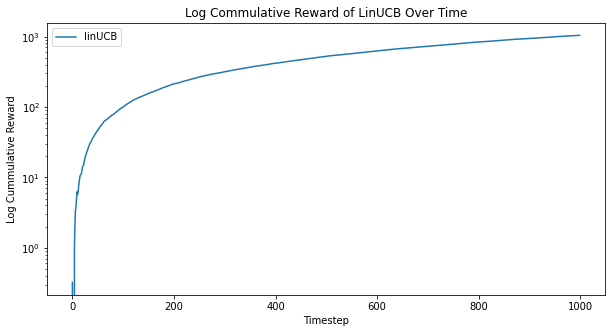

In [20]:
linucb.plot()

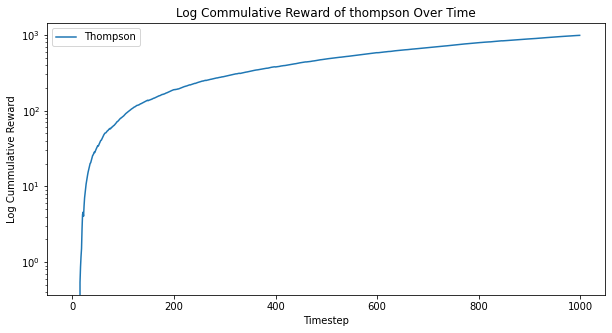

In [21]:
thompson.plot()

In [22]:
def visual_comparator(args):
    assert hasattr(args,'__iter__')
    # add class check
    fig = plt.figure(figsize = (10, 5))
    for it in args:

        plt.plot([i for i in range(len(it.reward_collector))], it.reward_collector,label=f"{it.__class__.__name__}") # plot cumsum per bandit.

    plt.legend()
    plt.xlabel("Timestep")
    plt.ylabel("Log Cummulative Reward")
    plt.title("Log Commulative Reward of LinUCB Over Time")
    plt.yscale("log")
    plt.show() 

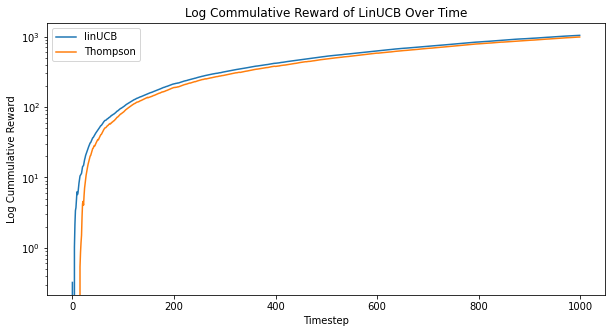

In [23]:
visual_comparator([linucb,thompson])

In [ ]:
assert self.experiment_indicator==True
        
        fig = plt.figure(figsize = (10, 5))

        plt.subplot(1,2,1)
        for it in range(len(self.reward_per_user)):
            plt.plot([i for i in range(len(self.reward_per_user[it]))], np.cumsum(self.reward_per_user[it]),label=f"user{it}") # plot cumsum per bandit.
            
        plt.legend()
        plt.xlabel("Timestep")
        plt.ylabel("Log Cummulative Reward")
        plt.title("Log Commulative Reward of LinUCB Over Time")
        plt.yscale("log")

        plt.subplot(1,2,2)
        plt.bar(["Optimal", "Non-optimal"],[self.num_optimal,self.num_iterations*len(self.user_contexts)-self.num_optimal],label=f"LinUCB")
        plt.legend()
        plt.ylabel("#optimal choices")
        plt.title("Number of optimal choices during the experiment")

        plt.show()

In [24]:
import unittest
class TestLinucbArm(unittest.TestCase):
    def TestConvergence(self):
        reward_matrix = user_contexts@bandit_contexts.T
        test_arm = linucb_arm(len(user_contexts[0]),1)
        for j in range(len(user_contexts)):
            true_val = reward_matrix[j][0]
            for i in range(100000):
                test_arm.update(user_contexts[j],true_val)
            test_val = test_arm.pull(user_contexts[j])[0][0]
            self.assertTrue(abs(test_val-true_val)<=0.01, "LinUCB not converging")

class TestLinucbArmManager(unittest.TestCase):
    def TestManagerConvergence(self):
        reward_matrix = user_contexts@bandit_contexts.T
        linucb_experiment = linucb_test_experiment_manager(user_contexts=user_contexts, bandit_contexts=bandit_contexts, num_iterations=10000, alpha=1)
        linucb_experiment.experiment()
        self.assertTrue(np.all(np.abs(linucb_experiment.experiment()-np.max(user_contexts@bandit_contexts.T,axis=1))<=0.02), "LinUCB items not converging")
        

class TestLinucb(unittest.TestCase):
    def TestSoleConvergence(self):
        reward_matrix = user_contexts@bandit_contexts.T
        for user in range(len(user_contexts)):
            for i in range(10000):
                res = linucb.ask(user_contexts[user])
                linucb.update(reward_matrix[user][res])
            self.assertEqual(linucb.ask(user_contexts[user]),np.argmax(reward_matrix[user]), "LinUCB Sole not converging")